In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import fitsio
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import vaex as vx
import easyaccess as ea
from descolors import BAND_COLORS
%matplotlib inline

# Iterative open FITS

In [2]:
def get_all(pattern, columns=None):
    """ Function to get the FITS files into a single record array
    """
    if (not isinstance(columns, list)):
        print("If no list of keys is input, then all are retrieved")
    counter = True
    t0 = time.time()
    for root, dirnm, filenm in os.walk(os.getcwd()):
        for idx, f in enumerate(filenm):
            if (pattern in f):
                # Get the file extension
                aux_fnm, aux_extension = os.path.splitext(f)
                if (aux_extension.upper() == ".FITS"):
                    hdu = fitsio.FITS(f)
                    if counter:
                        if (columns is None):
                            r_arr = hdu[1].read()
                        else:
                            r_arr = hdu[1].read()[columns]
                        counter = False
                    else:
                        if (columns is None):
                            r_arr = np.concatenate((r_arr, hdu[1].read()))
                        else:
                            r_arr = np.concatenate((r_arr, hdu[1].read()[columns]))
                    hdu.close()
                    print("{0} loaded".format(f))
                elif ((aux_extension.upper == ".h5") or (aux_extension.upper == ".hdf5")):
                    
                    
                    pass
                    # load the entire file and then subsample inside the df
                    
                    
                else:
                    print("ERROR")
    print("Elapsed time in reading the FITS: {0:.2f} min".format((time.time() - t0) / 60.))
    return r_arr

#### Below function is not optimal for N>1e4 because of the query time

In [3]:
def get_imaflags_iso(id_list, band=["g", "r", "i", "z", "Y"], dbname="dessci"):
    """ Function to retrieve the IMAFLAG_ISO from the Y3A2_COADD_OBJECT_SUMMARY table, per band
    """
    aux_col = ",".join(["IMAFLAGS_ISO_{0}".format(b.upper()) for b in band])
    aux_id = ",".join(map(str, id_list))
    q = "select COADD_OBJECT_ID,{0}".format(aux_col)
    q += " from Y3A2_COADD_OBJECT_SUMMARY"
    q += " where COADD_OBJECT_ID in ({0})".format(aux_id)
    q += " order by COADD_OBJECT_ID"
    connect = ea.connect(dbname)
    cursor = connect.cursor()
    df_res = connect.query_to_pandas(q)
    connect.close()
    return df_res

### Get the data. A previous mag_iso_{band} < 21 cut was applied

In [16]:
tab = get_all("Y3A2_COADD_SUMMARY_mag21_extwavg_flags.fits") 
#("Y3A2_COADD_OBJECT_flux_extwavg_radius")
# table "Y3A2_COADD_OBJECT_mag_extwavg_small.fits" doesn't comntain FLAG info and is only mag-restricted to be 
# mag_auto_i < 21
#
# x = pd.read_hdf("Y3A2_COADD_OBJECT_flux_extwavg_radius_000001.fits")
# y = pd.read_hdf("dr1_band_i_10pcent_20171101_000001.h5")
# z = pd.concat([x, y])
# x.info()

If no list of keys is input, then all are retrieved
Y3A2_COADD_SUMMARY_mag21_extwavg_flags.fits loaded
Elapsed time in reading the FITS: 0.01 min


## FITS are loaded in big-endian, and pandas needs it in little-endian, so must change it

In [17]:
tab = tab.byteswap().newbyteorder()

### For easier usage, pass recarray to pandas dataframe

In [18]:
kw0 = tab.dtype.names
val0 = [tab[i] for i in kw0]
d = dict(zip(kw0, val0))

In [21]:
df = pd.DataFrame(d)
df.columns

Index(['COADD_OBJECT_ID', 'EXT_WAVG', 'FLAGS_G', 'FLAGS_I', 'FLAGS_R',
       'FLAGS_Y', 'FLAGS_Z', 'G_MAG_APER_1', 'G_MAG_APER_10', 'G_MAG_APER_11',
       'G_MAG_APER_12', 'G_MAG_APER_2', 'G_MAG_APER_3', 'G_MAG_APER_4',
       'G_MAG_APER_5', 'G_MAG_APER_6', 'G_MAG_APER_7', 'G_MAG_APER_8',
       'G_MAG_APER_9', 'G_MAG_AUTO', 'G_MAG_PETRO', 'G_WAVG_MAG_PSF',
       'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_I', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_Y',
       'IMAFLAGS_ISO_Z', 'I_MAG_APER_1', 'I_MAG_APER_10', 'I_MAG_APER_11',
       'I_MAG_APER_12', 'I_MAG_APER_2', 'I_MAG_APER_3', 'I_MAG_APER_4',
       'I_MAG_APER_5', 'I_MAG_APER_6', 'I_MAG_APER_7', 'I_MAG_APER_8',
       'I_MAG_APER_9', 'I_MAG_AUTO', 'I_MAG_PETRO', 'I_WAVG_MAG_PSF',
       'R_MAG_APER_1', 'R_MAG_APER_10', 'R_MAG_APER_11', 'R_MAG_APER_12',
       'R_MAG_APER_2', 'R_MAG_APER_3', 'R_MAG_APER_4', 'R_MAG_APER_5',
       'R_MAG_APER_6', 'R_MAG_APER_7', 'R_MAG_APER_8', 'R_MAG_APER_9',
       'R_MAG_AUTO', 'R_MAG_PETRO', 'R_WAVG_MAG_PSF', 

### Need to discard magnitudes +/- 99
#### Is a little slow, maybe change to df.drop(index, inplace=True)

In [23]:
for B in ["g", "r", "i", "z", "Y"]:
    # Expliciting conditions
    c99_a = ~((df["{0}_MAG_AUTO".format(B.upper())] == -99) | (df["{0}_MAG_AUTO".format(B.upper())] == 99))
    c99_b = ~((df["{0}_MAG_PETRO".format(B.upper())] == -99) | (df["{0}_MAG_PETRO".format(B.upper())] == 99))
    c99_c = ~((df["{0}_WAVG_MAG_PSF".format(B.upper())] == -99) | (df["{0}_WAVG_MAG_PSF".format(B.upper())] == 99))
    # Drop rows obeying the condition
    df = df.loc[c99_a]
    df = df.loc[c99_b]
    df = df.loc[c99_c]
    for AP in np.arange(1, 13):
        aux_mag = "{0}_MAG_APER_{1}".format(B.upper(), AP)
        c99_aper = ~((df[aux_mag] == -99) | (df[aux_mag] == 99))
        df = df.loc[c99_aper]
# Reset indices
df.reset_index(inplace=True)

# Profile plots using aperture magnitude

### Plot per band

In [50]:
bs = ["g", "r", "i", "z", "Y"]
ap = np.arange(1, 13) 

### Make copies of the DataFrame to safely play with them

In [51]:
df_aux1 = df.copy(deep=True)
df_aux2 = df.copy(deep=True)

### Normalize each object set of magnitudes using MAG_APER_4

In [52]:
# For df_aux1. This method does some weird shape
for b in bs:
    for a in ap:
        aux_key = "{0}_MAG_APER_{1}".format(b.upper(), a)
        aux_key_ap4 = "{0}_MAG_APER_4".format(b.upper())
        df_aux1[aux_key] -= df[aux_key_ap4]

# for idx, row in df.iterrows():
#     for b in bs:
#         for a in ap:
#             aux_key = "{0}_MAG_APER_{1}".format(b.upper(), a)
#             aux_key_ap4 = "{0}_MAG_APER_4".format(b.upper())
#             row[aux_key] /= row[aux_key_ap4]

### PHOT_APERTURES  1.85, 3.70, 5.55, 7.41, 11.11, 14.81, 18.52, 22.22, 25.93, 29.63, 44.44, 66.67   MAG_APER aperture diameter(s) in pixels

In [53]:
PHOT_APERTURES = [1.85, 3.70, 5.55, 7.41, 11.11, 14.81, 18.52, 22.22, 25.93, 29.63, 44.44, 66.67]
PHOT_APERTURES = [0.27 * x for x in PHOT_APERTURES]

In [65]:
def plot_aper(df, band="g", EXT_WAVG=0, FLAGS=0, IMAFLAGS=0):
    aux0 = ["{0}_MAG_APER_{1}".format(band.upper(), x) for x in ap]
    v5, v25, v50, v75, v95 = [], [], [], [], []

    aux_flags = "FLAGS_{0}".format(band.upper())
    aux_imaflags = "IMAFLAGS_ISO_{0}".format(band.upper())
    cond = ((df["EXT_WAVG"] == EXT_WAVG) & (df[aux_flags] <= FLAGS) & (df[aux_imaflags] == IMAFLAGS))
    for c in aux0:
        v5.append(np.percentile(df.loc[cond, c].values, 5))
        v25.append(np.percentile(df.loc[cond, c].values, 25))
        v50.append(np.percentile(df.loc[cond, c].values, 50))
        v75.append(np.percentile(df.loc[cond, c].values, 75))
        v95.append(np.percentile(df.loc[cond, c].values, 95))
    
    plt.close("all")
    fig, ax = plt.subplots(figsize=(8,6))
    ax2 = ax.twiny()
    
    ax.plot(PHOT_APERTURES, v50, color=BAND_COLORS[band], linestyle="-", lw=4, label="Median, {0}-band".format(band))
    ax.fill_between(PHOT_APERTURES, v25, v5, color="royalblue", alpha=0.4)
    ax.fill_between(PHOT_APERTURES, v95, v75, color="royalblue", alpha=0.4)
    ax.fill_between(PHOT_APERTURES, v50, v25, color="lightyellow", alpha=0.8)
    ax.fill_between(PHOT_APERTURES, v75, v50, color="lightyellow", alpha=0.8)
    
    # New axis locations
    new_tick_locations = PHOT_APERTURES
    APER = np.arange(1, 13)
    
    plt.legend(loc="upper left")
    tt = "{0}-band, contours for 5-25%, 25-75%, 75-95%.".format(band)
    tt += " Sample of {0:.1E} objects.\n MAG_ISO_{1} < 21, EXT_WAVG={2}".format(len(df.loc[cond].index), 
                                                                                band.upper(), EXT_WAVG)
    tt += ", {0}<={1}, {2}={3}".format(aux_flags, FLAGS, aux_imaflags, IMAFLAGS)
    plt.suptitle(tt)
    
    ax.set_xlabel(r"PHOT_APERTURES  $asec$")
    ax.set_ylabel(r"MAG_APER - MAG_APER_4  $mag$")
    
    ax.set_xlim(min(PHOT_APERTURES), max(PHOT_APERTURES))
    #ax.set_ylim([min(v5), max(v95)])
    
    #  Values and tics for auxiliary x-axis
    ax2.set_xlim(min(PHOT_APERTURES), max(PHOT_APERTURES))#[lim[0] * 3600 * 1000, lim[1] * 3600 * 1000])
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(APER)
    ax2.set_xlabel(r"APER")
    #ax2.set_xlim([-6e-7 * 3600 * 1000, 6e-7 * 3600 * 1000]) # plt.xlim())
    
    
    # Add minor tics
    # Use Auto Minor Locator
    minorLocator_x = AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocator_x)
    minorLocator_y = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocator_y)
    #
    minorLocator_x2 = AutoMinorLocator()
    ax2.xaxis.set_minor_locator(minorLocator_x2)
    
    plt.subplots_adjust(top=0.81)
    
    outname = "growth_{0}_extwavg{1}_flags{2}.png".format(band, EXT_WAVG, FLAGS)
    plt.savefig(outname, dpi=500, format="png")

### For EXT_WAVG==0

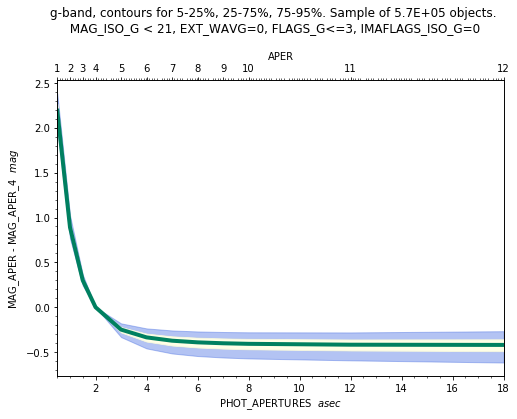

In [66]:
plot_aper(df_aux1, band="g", FLAGS=3)

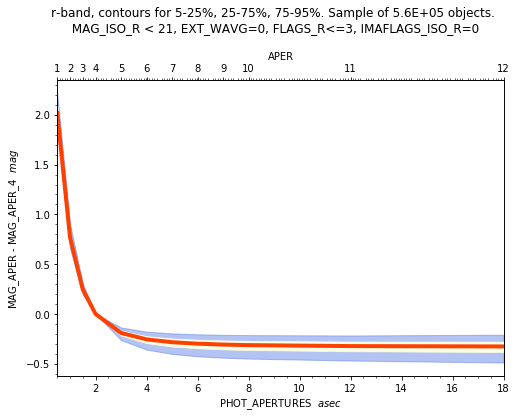

In [67]:
plot_aper(df_aux1, band="r", FLAGS=3)

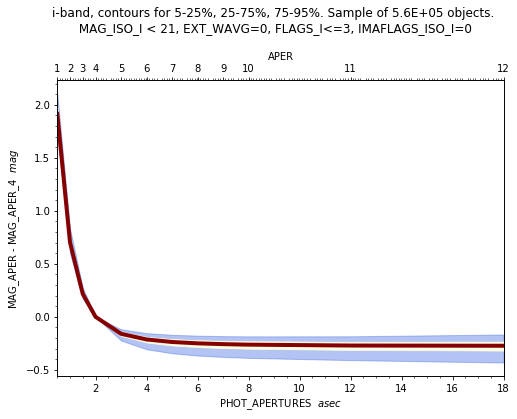

In [68]:
plot_aper(df_aux1, band="i", FLAGS=3)

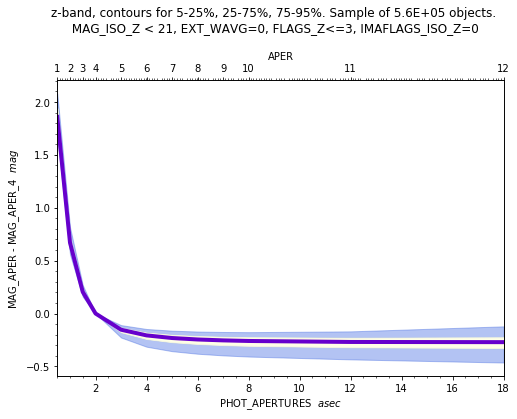

In [69]:
plot_aper(df_aux1, band="z", FLAGS=3)

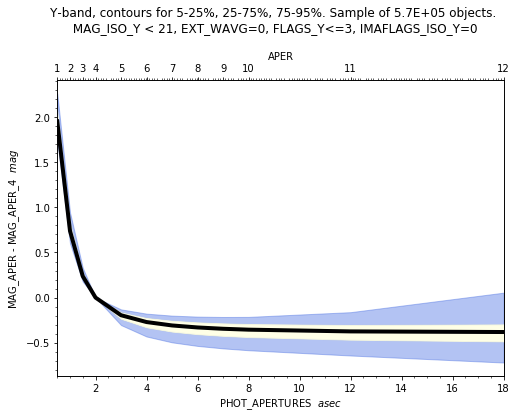

In [70]:
plot_aper(df_aux1, band="Y", FLAGS=3)

### For EXT_WAVG==3

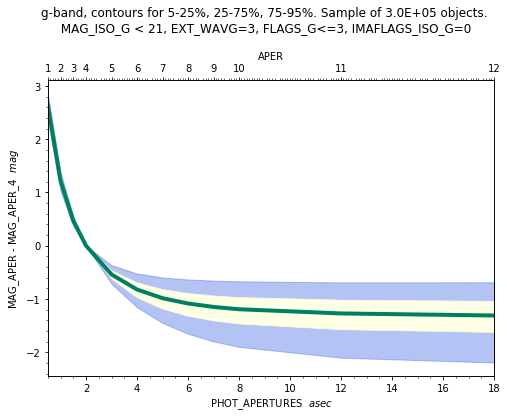

In [71]:
plot_aper(df_aux1, band="g", FLAGS=3, EXT_WAVG=3)

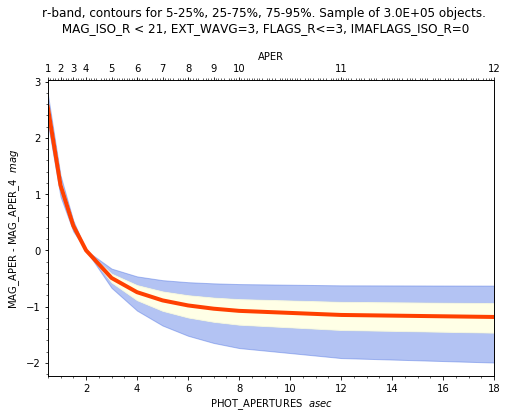

In [72]:
plot_aper(df_aux1, band="r", FLAGS=3, EXT_WAVG=3)

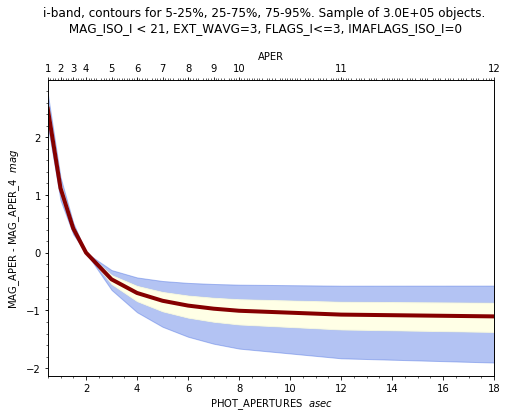

In [73]:
plot_aper(df_aux1, band="i", FLAGS=3, EXT_WAVG=3)

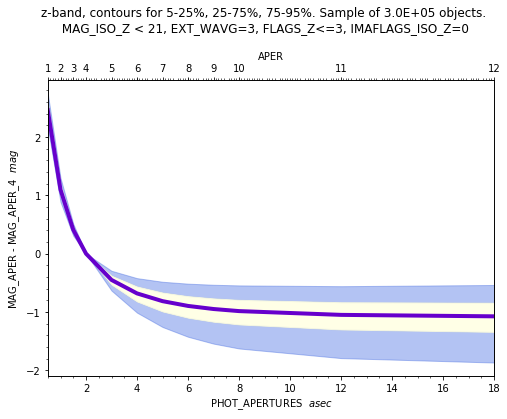

In [74]:
plot_aper(df_aux1, band="z", FLAGS=3, EXT_WAVG=3)

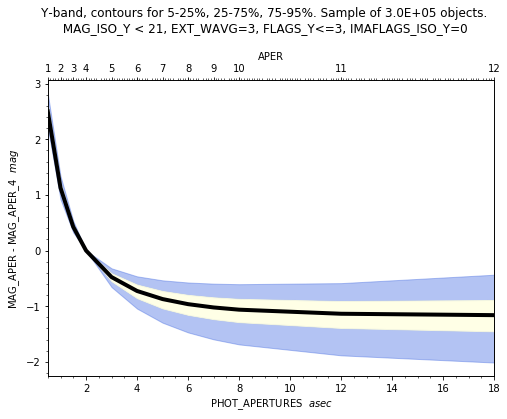

In [75]:
plot_aper(df_aux1, band="Y", FLAGS=3, EXT_WAVG=3)